In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import matplotlib as mpl

In [3]:
# readin cvtk packages.

from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [5]:
np.random.seed(0)

# Data and Annotation Loading

### Load in allele frequency file

Here, we only actually have 2 controls. So I needed to duplicate these. This will likely cause problems downstream with the covariance estimations.

In [6]:
CACHED_SYNC = '../data/barghi_et_al_2019/variants.hdf5'
SYNC_FILE = '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz'
#if not os.path.exists(CACHED_SYNC):
#    sf = vf.SyncFile(SYNC_FILE)
#    sf.dump_hdf5(CACHED_SYNC)
#else:
#    sf = vf.SyncFile.load_hdf5(CACHED_SYNC)

sf = vf.SyncFile(SYNC_FILE)
sf

reading file '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz'...
file '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz' loaded.
total time to load Sync file: 0.25559659401575724 mins.


VariantFile with 166090 loci and 32 samples.

#### Next, need a file that specifies the genome. in format: scaff name, length. tab delimited.

2L  21089  
2Lhet  33005

In [7]:
sf_gi = sf.build_gintervals()
sf_gi.seqlens = dict()
with open('/users/r/b/rbrennan/tonsa_genomics/analysis/tonsa_seqlens.txt') as f:
    for line in f:
        seqid, length = line.strip().split('\t')
        sf_gi.seqlens[seqid] = int(length)

In [8]:
sf_gi

GenomicIntervals — 9473 unique seqids, 166090 features
         GenomicInterval
0  LS387016.1:[102, 103)
1  LS387016.1:[148, 149)
2  LS387016.1:[158, 159)
3  LS387016.1:[162, 163)
4  LS387016.1:[163, 164)
[ 166085 more GenomicIntervals ]

In [9]:
#keep_seqids = ['2L', '2R', '3L', '3R', 'X']
#keep_autos = ['2L', '2R', '3L', '3R']

### Study Design

Next, we parse the sample names. The format of this final file is:

|name|species|pop|selection|gen|rep|
|---|---|---|---|---|---|
|Dsim_Fl_Base_1|Dsim|Fl|Base|0|1|  
|Dsim_Fl_Base_2|Dsim|Fl|Base|0|2|

These should be in the order of the sync file and saved as csv.

In [10]:
RAW_DESIGN_FILE = '/users/r/b/rbrennan/tonsa_genomics/analysis/tonsa_design.csv'
sample_names = pd.read_csv(RAW_DESIGN_FILE)
#sample_re = re.compile(r"(?P<species>Dsim)_(?P<pop>Fl)_(?P<selection>Base|Hot)_(F(?P<gen>\d+)_)?(?P<rep>\d+)")
#sample_info = [{'name':d, **re.match(sample_re, d).groupdict()} for d in sample_names]
design = sample_names

In [11]:
design

,name,species,pop,selection,gen,rep,id
0,AA_F00_Rep1,Atonsa,LIS,Ambient,0,1,AA-1
1,AA_F00_Rep2,Atonsa,LIS,Ambient,0,2,AA-2
2,AA_F00_Rep3,Atonsa,LIS,Ambient,0,3,AA-3
3,AA_F00_Rep4,Atonsa,LIS,Ambient,0,4,AA-4
4,AA_F25_Rep1,Atonsa,LIS,Ambient,25,1,AA-1
5,AA_F25_Rep2,Atonsa,LIS,Ambient,25,2,AA-2
6,AA_F25_Rep3,Atonsa,LIS,Ambient,25,3,AA-3
7,AA_F25_Rep4,Atonsa,LIS,Ambient,25,4,AA-4
8,AA_F00_Rep1,Atonsa,LIS,Acidic,0,1,AH-1
9,AA_F00_Rep2,Atonsa,LIS,Acidic,0,2,AH-2


Our `TemporalFreqs()` and `TiledTemporalFreqs()` objects take a list of tuples `(replicate, timepoint)`, which we create via the design DataFrame:

In [12]:
samples = design[['id', 'gen']].copy().values.tolist()

#np.shape(samples)
#samples = [(t, r) for t, r in (design['id'].values, design['gen'].values)]
#samples = design['id','gen'].tolist()
#print(design['id'].values)
#print(design['gen'].values)
samples

[['AA-1', 0],
 ['AA-2', 0],
 ['AA-3', 0],
 ['AA-4', 0],
 ['AA-1', 25],
 ['AA-2', 25],
 ['AA-3', 25],
 ['AA-4', 25],
 ['AH-1', 0],
 ['AH-2', 0],
 ['AH-3', 0],
 ['AH-4', 0],
 ['AH-1', 25],
 ['AH-2', 25],
 ['AH-3', 25],
 ['AH-4', 25],
 ['HA-1', 0],
 ['HA-2', 0],
 ['HA-3', 0],
 ['HA-4', 0],
 ['HA-1', 25],
 ['HA-2', 25],
 ['HA-3', 25],
 ['HA-4', 25],
 ['HH-1', 0],
 ['HH-2', 0],
 ['HH-3', 0],
 ['HH-4', 0],
 ['HH-1', 25],
 ['HH-2', 25],
 ['HH-3', 25],
 ['HH-4', 25]]

### Import Annotation

These sequence lengths are used for the creation of the tiles.

In [13]:
gff_file = '/users/r/b/rbrennan/tonsa_annotation/gawn/05_results/GCA_900241095.1_Aton1.0_genomic.fa.gff3'
# remove keep seqids, I want to keep all
#keep_seqids = set('2L 2R 3L 3R 4 X'.split())
#dsim = GenomicIntervals.from_gff(gtf_file, filter_type='exon', filter_seqids=keep_seqids, delims=(' ', '; '))
atonsa = GenomicIntervals.from_gff(gff_file, filter_type='exon')
#atonsa = GenomicIntervals.from_gff(gff_file)

In [14]:
atonsa.infer_seqlens()

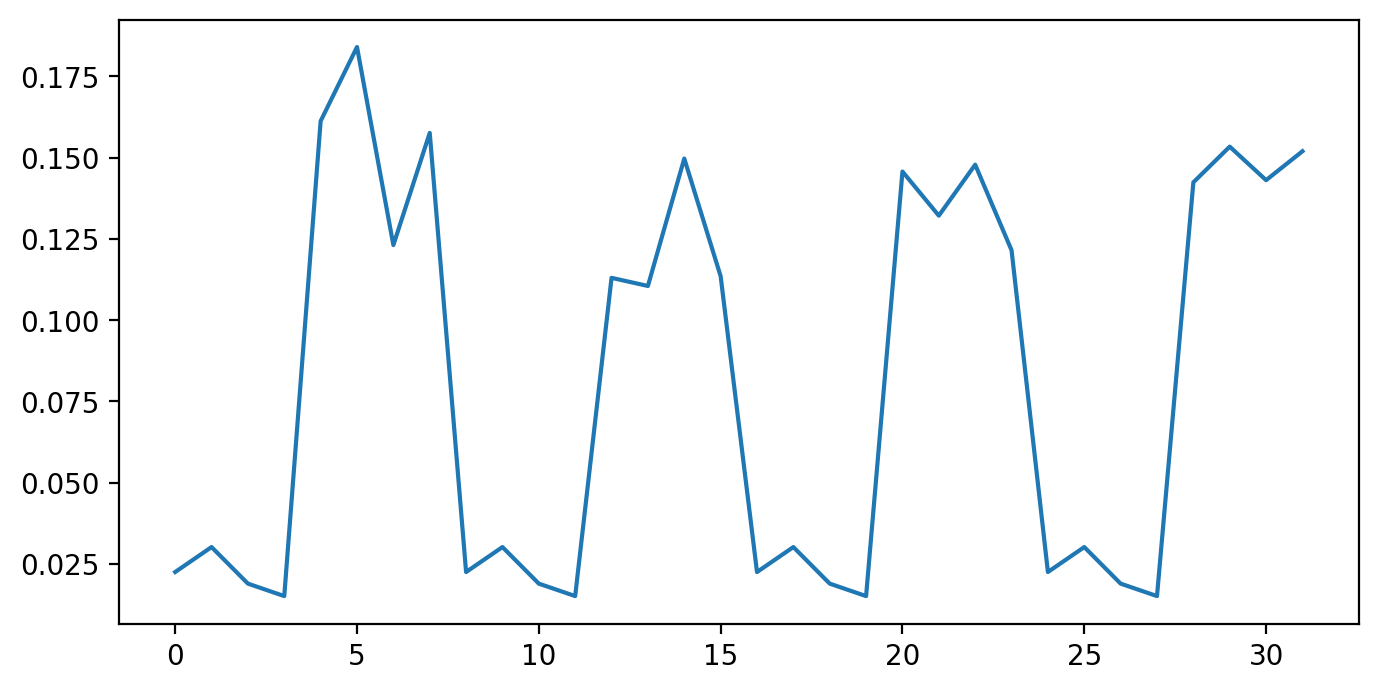

In [15]:
fixed = ((sf.freqs == 0.) | (sf.freqs == 1.))
# what percent of sites are fixed/lost through time?
plt.plot(fixed.mean(axis=0))

In [16]:
tile_width = 1e6
tile_width_label = '1e6'
tiles = GenomicIntervals.from_tiles(atonsa.seqlens, width=tile_width, drop_last_tile=False)
#tiles.intervals

In [17]:
d = TiledTemporalFreqs(tiles, freqs=sf.freqs.T, depths=sf.N.T, diploids=3000, gintervals=sf_gi, samples=samples,
                       share_first=True)

In [18]:
d.freqs.shape

(16, 2, 166090)

How many windows and what's the mean and median number of loci per window?

In [19]:
nloci = np.array([len(x) for x in d.tile_indices])

d_noempty = [ele for ele in d.tile_indices if ele != []]
print(len(d_noempty))
print(len(d.tile_indices))

print(f"mean number of loci: {nloci.mean()}")
print(f"median number of loci: {np.median(nloci)}")

8200
34195
mean number of loci: 4.272115806404445
median number of loci: 0.0


Most windows are empty. I think this is causing errors below.

### Genome-wide Covariances

In [20]:
gw_covs = d.calc_cov(use_masked=True, standardize=True)

In [21]:
gw_covs.shape

(16, 16)

In [22]:
stack_temporal_covariances(gw_covs, d.R, d.T).mean(axis=2)

array([[0.04441293]])

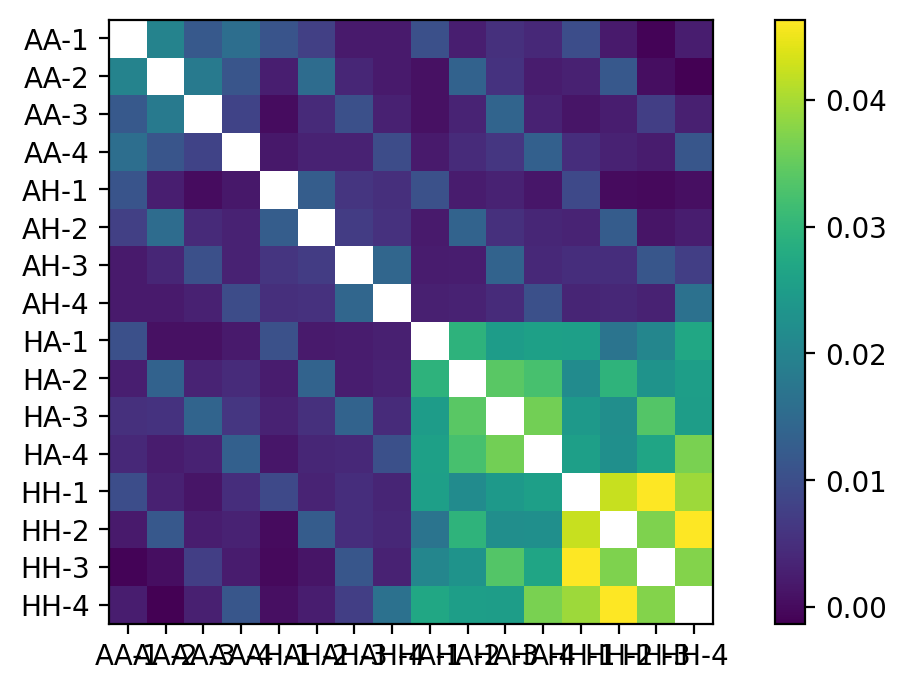

In [23]:
np.fill_diagonal(gw_covs, np.nan)
fig, ax = plt.subplots()
ax.imshow(gw_covs)
img1 = ax.imshow(gw_covs)
fig.colorbar(img1, ax=ax)
sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]
ax.set_xticklabels(sample_names)
ax.set_yticklabels(sample_names)
#print( design['name'])
ax.set_xticks(np.arange(len(sample_names)))
ax.set_yticks(np.arange(len(sample_names)))
plt.show()

## Filter windows

As this currently stands, it is filtering based on scaffold id. So we're left with many empty windows.

In [24]:
#d.tile_df['uniqid'] = d.tile_df['seqid'] + "_" + d.tile_df['midpoint'].astype(str)
min_sites = 10
keep_seqids = list(set([str(chr) for chr, indices in zip(d.tile_df['seqid'], d.tile_indices) if len(indices) > min_sites]))
#sel_chrs = ['24', '1', '9', '15']
#sel_chrs = ['24']
sel_chrs = []
keep_seqids = [chr for chr in keep_seqids if chr not in sel_chrs]

print(len(keep_seqids))

print(len(d.tile_indices))

print(keep_seqids[0:10])


4713
34195
['LS047723.1', 'LS054330.1', 'LS050242.1', 'LS199408.1', 'LS079464.1', 'LS044924.1', 'LS180820.1', 'LS048982.1', 'LS053324.1', 'LS079716.1']


In [25]:
exclude_seqids = list(set(d.gintervals.keys()) - set(keep_seqids))
#len(exclude_seqids)
len(keep_seqids)


4713

### Bootstrap whole covaraince matrix.

In [26]:
gw_covs_cis = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=keep_seqids,
                              average_replicates=False, use_masked=True)
#print(gw_covs_cis)

/data/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/cvtk/cov.py:284: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/data/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/cvtk/cov.py:345: RuntimeWarning: Mean of empty slice
  ave_bias += np.nanmean(0.5 * hets * (diploid_correction + depth_correction), axis=2)


<ipython-input-27-d3cc3981c7ef>:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemline, baseline, = plt.stem(all_labels, mean,linefmt='k--', bottom = -0.01)


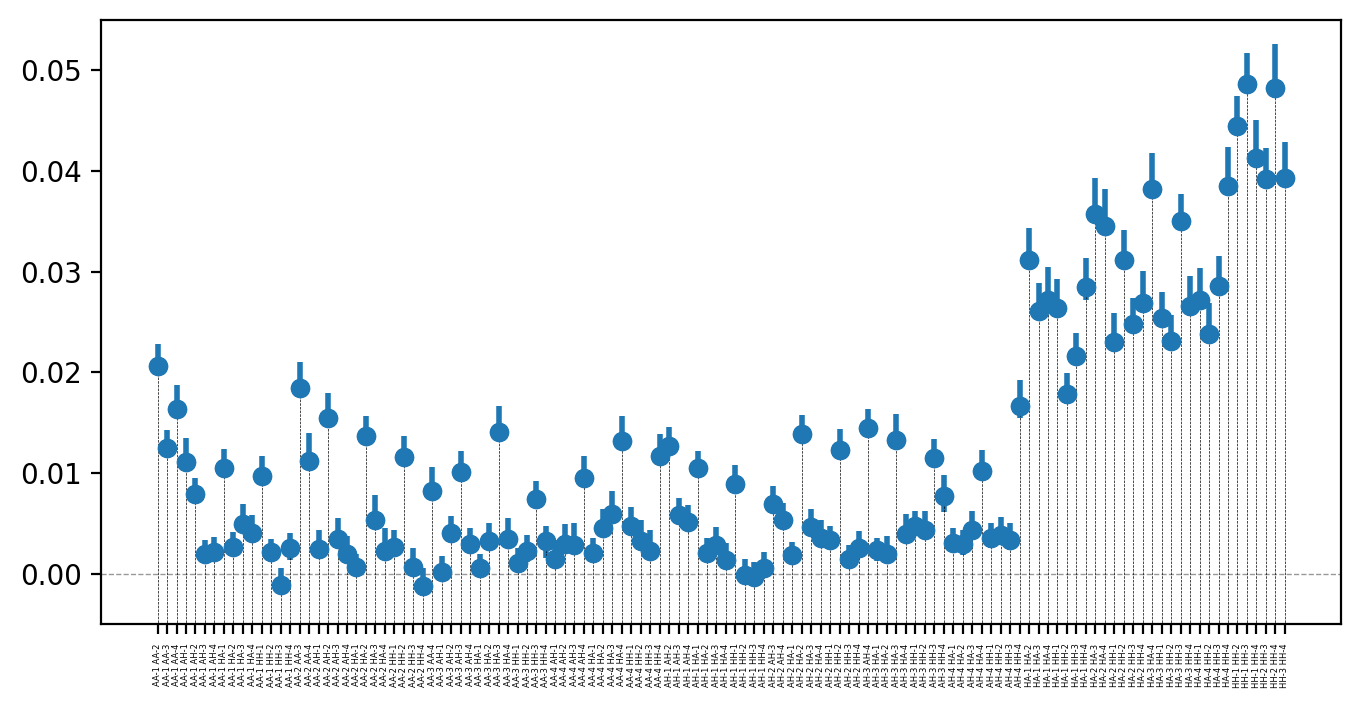

In [27]:
def rep_cov_plot(cis, labels=''):
    rows, cols = np.triu_indices(cis.shape[1], k=1)
    lower, mean, upper = [cis[i, rows, cols].ravel() for i in np.arange(3)]
    all_labels = [labels[i] + " " + labels[j] for i, j in zip(rows, cols)]
    lower, upper = mean-lower, upper-mean
    bounds = np.stack([lower, upper])
    plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='o', linewidth=1.5, elinewidth=2)
    plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
    plt.xticks(rotation='vertical',fontsize=3)
    markerline, stemline, baseline, = plt.stem(all_labels, mean,linefmt='k--', bottom = -0.01)
    plt.setp(stemline, linewidth = 0.25)
    plt.setp(baseline, 'linewidth', 0)
    plt.ylim([-0.005, 0.055])


sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]

rep_cov_plot(gw_covs_cis, sample_names)

In [28]:
print(gw_covs_cis)

[[[ 4.85795312e-02  2.02746565e-02  1.18473991e-02  1.61127828e-02
    1.14864215e-02  7.27983163e-03  1.20354241e-03  1.33184560e-03
    1.01613345e-02  1.84409874e-03  4.33627295e-03  3.22134295e-03
    9.05977384e-03  1.17411026e-03 -1.81883429e-03  1.39051306e-03]
  [ 2.02746565e-02  4.97558876e-02  1.83444348e-02  1.11211466e-02
    2.22833999e-03  1.54348028e-02  2.99370045e-03  1.31735218e-03
   -2.67286866e-04  1.30169052e-02  4.93835827e-03  1.89170620e-03
    1.83251073e-03  1.10930215e-02 -9.39425738e-06 -2.22715070e-03]
  [ 1.18473991e-02  1.83444348e-02  3.75871173e-02  7.96504753e-03
   -2.81511200e-04  3.46318065e-03  9.76035899e-03  2.00026523e-03
   -1.45160369e-04  2.62291503e-03  1.39759124e-02  2.94482486e-03
    1.18747971e-04  1.14247858e-03  6.76301019e-03  1.58233174e-03]
  [ 1.61127828e-02  1.11211466e-02  7.96504753e-03  4.32647129e-02
    1.08703843e-03  2.52308114e-03  2.44943480e-03  9.06820138e-03
    1.12172414e-03  3.84514154e-03  5.34303416e-03  1.28025

In [29]:
pca = FreqPCA(sf.freqs)
pc_df= pca.to_df()
# add in the sample info:
pc_df[['rep', 'gen', 'id', 'selection']] = design[['rep', 'gen', 'id', 'selection']]
#pc_df.to_csv('../data/e/pca_df.csv', index=False)


[2.44126727e-01 1.19616623e-01 7.97080777e-02 6.65235135e-02
 5.13728763e-02 4.79454608e-02 4.10488356e-02 4.07896081e-02
 3.64815682e-02 3.55398993e-02 3.36821616e-02 3.27103153e-02
 3.03788341e-02 2.55850258e-02 2.52654196e-02 2.44963441e-02
 2.27156502e-02 2.19216985e-02 2.00913615e-02 7.12557156e-30
 9.35461306e-31 1.36873250e-31 3.47585762e-32 1.05895176e-32
 1.09961019e-33 1.09961019e-33 1.09961019e-33 1.09961019e-33
 1.09961019e-33 1.09961019e-33 1.09961019e-33 2.64758569e-34]


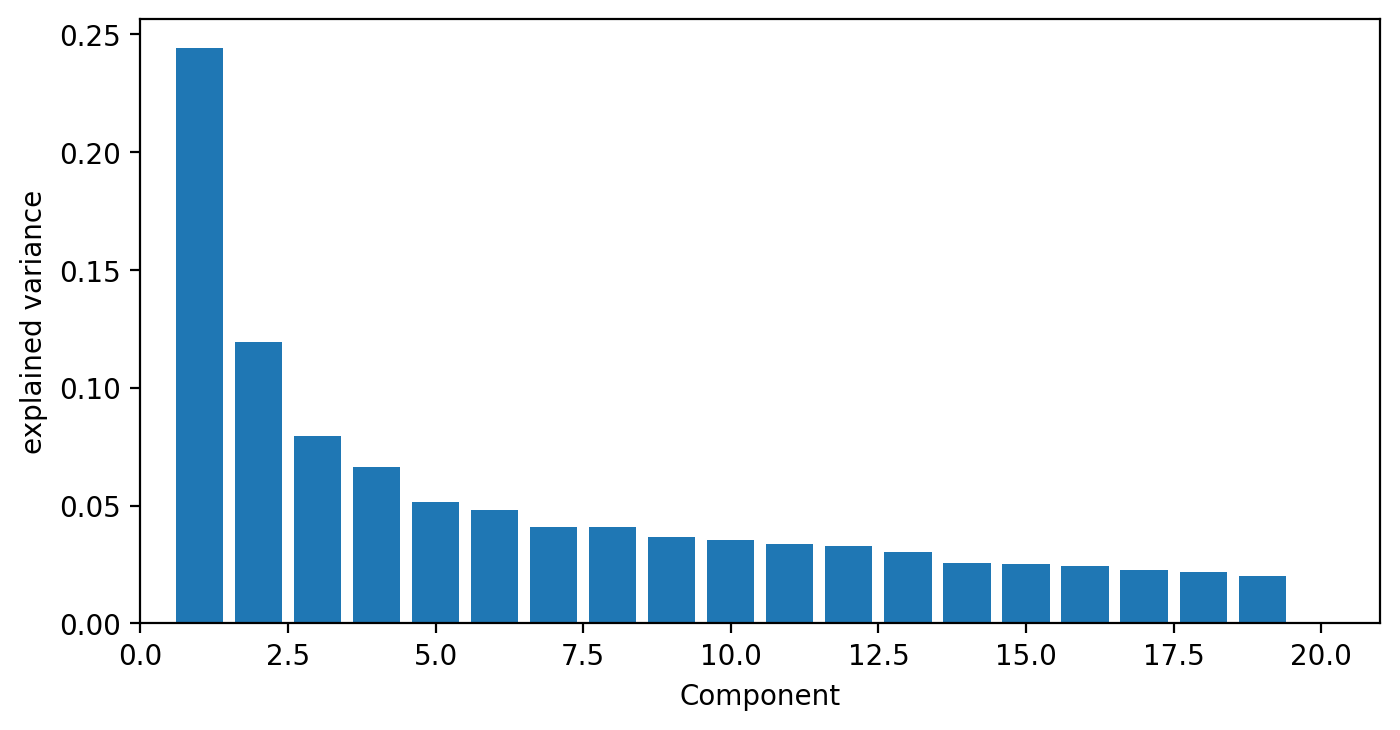

In [30]:
explained_variance_ratio = pca.explained_variance / np.sum(pca.explained_variance)
print(explained_variance_ratio)
len(np.cumsum(explained_variance_ratio))
plt.bar(range(1,33),explained_variance_ratio)
plt.xlabel('Component')
plt.ylabel('explained variance')
#plt.ylim(0,1.05)
plt.xlim(0,21);

(<Figure size 1600x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99d5589f70>)

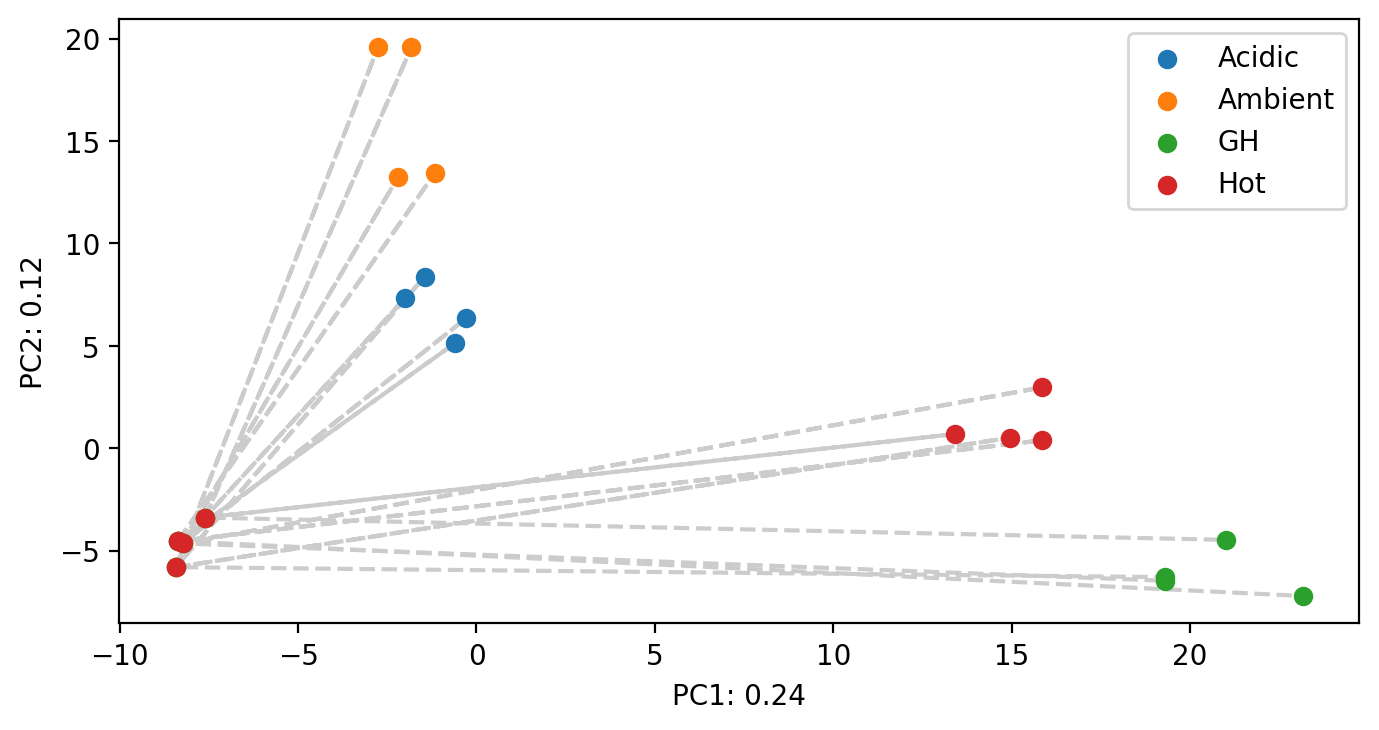

In [31]:
from cvtk.plots import rep_plot_pca3

explained_variance_ratio = pca.explained_variance / np.sum(pca.explained_variance)

rep_plot_pca3(pc_df, 1,2, variance=explained_variance_ratio, label=False)

## Bias correction

In [32]:
diagnostics = d.correction_diagnostics(exclude_seqids=exclude_seqids)
#_ = correction_diagnostic_plot(diagnostics, color=False)


/data/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/cvtk/cvtk.py:247: RuntimeWarning: Mean of empty slice.
  n = n.mean()
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/cvtk/cvtk.py:261: RuntimeWarning: Mean of empty slice.
  het = het.mean()
/data/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/cvtk/cov.py:284: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/cvtk/cov.py:316: RuntimeWarning: Degrees of

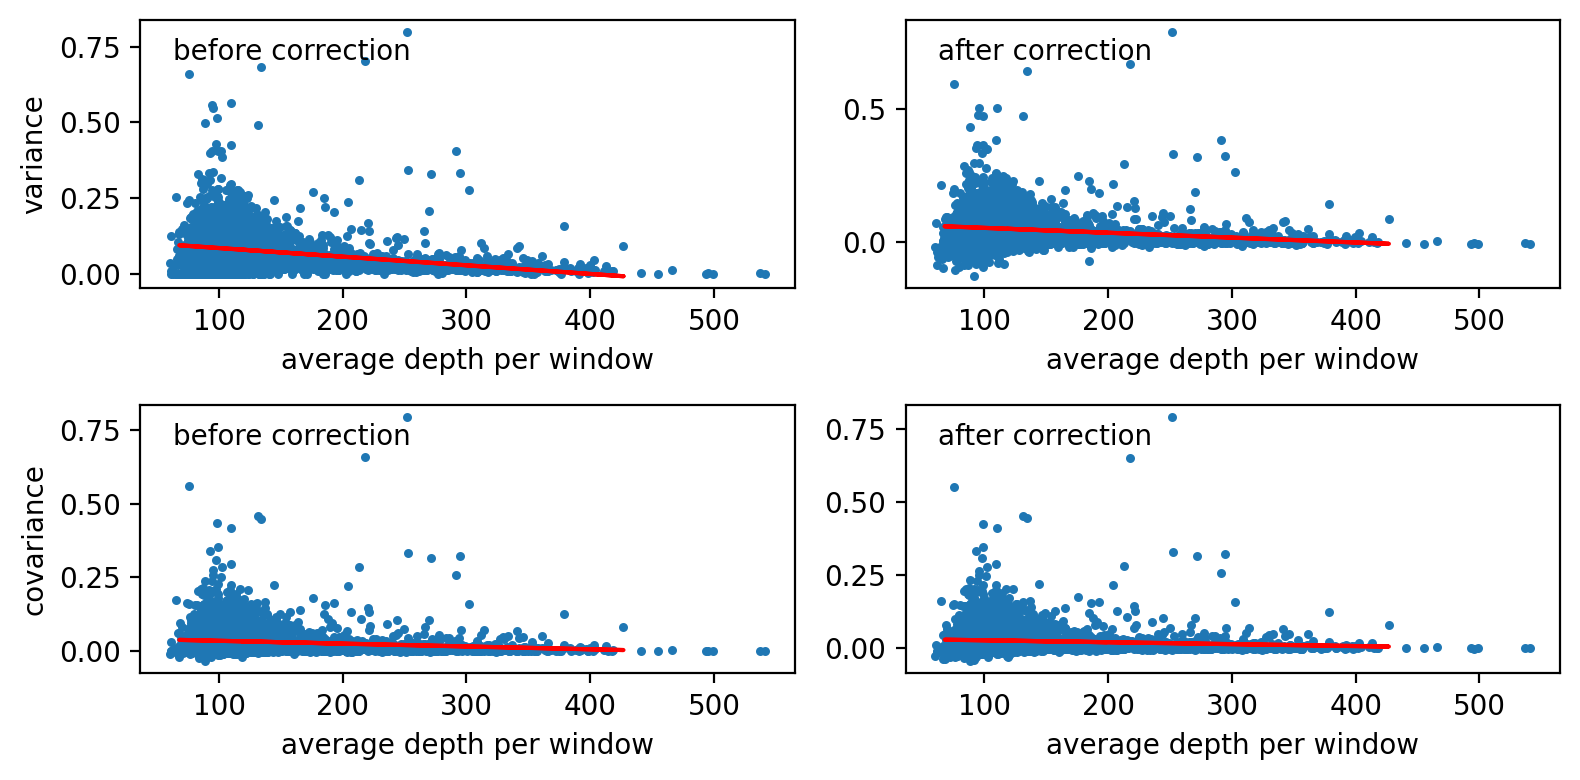

In [33]:
_ = correction_diagnostic_plot(diagnostics, color=False)

# had to remove the horizonal line to get this to run.


# Bootstrap Convergence Correlation


In [34]:
conv_corr = d.convergence_corr()
print(conv_corr)

[[[0.26149409]]]


In [35]:
convergence_corr = d.bootstrap_convergence_corr(B=5000, progress_bar=True)
print(convergence_corr)

/data/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/cvtk/cov.py:284: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/cvtk/cov.py:316: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(deltas, bias=True)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/data/users/r/b/rbr


[[[[0.26406961]]]


 [[[0.26149409]]]


 [[[0.29034647]]]]


# Convergent Correlation per Comparison

In [36]:
import itertools

In [39]:
#combs = list(itertools.combinations(range(0,16),2))
# just run a couple, to act as example
combs = list(itertools.combinations(range(0,8),2))

outlist = []

for x in combs:
    outlist.append(
                    d.bootstrap_convergence_corr(B=5000, 
                                                 progress_bar=False, subset=(x[0], x[1])))
    print("done with rep", x, "\n")    


done with rep (0, 1) 

done with rep (0, 2) 

done with rep (0, 3) 

done with rep (0, 4) 

done with rep (0, 5) 

done with rep (0, 6) 

done with rep (0, 7) 

done with rep (1, 2) 

done with rep (1, 3) 

done with rep (1, 4) 

done with rep (1, 5) 

done with rep (1, 6) 

done with rep (1, 7) 

done with rep (2, 3) 

done with rep (2, 4) 

done with rep (2, 5) 

done with rep (2, 6) 

done with rep (2, 7) 

done with rep (3, 4) 

done with rep (3, 5) 

done with rep (3, 6) 

done with rep (3, 7) 

done with rep (4, 5) 

done with rep (4, 6) 

done with rep (4, 7) 

done with rep (5, 6) 

done with rep (5, 7) 

done with rep (6, 7) 



In [40]:
combined_conv_corrs = np.stack(outlist).squeeze()

#combined_conv_corrs

combined_conv_corrs

array([[0.40592966, 0.42393843, 0.44105246],
       [0.28376182, 0.29855789, 0.32413726],
       [0.34372027, 0.36077167, 0.3817556 ],
       [0.35132887, 0.34100698, 0.3918299 ],
       [0.19659071, 0.20590813, 0.24068133],
       [0.05467088, 0.05868335, 0.10960253],
       [0.06643401, 0.0667089 , 0.11957776],
       [0.43269845, 0.43906446, 0.46896447],
       [0.24059712, 0.2497477 , 0.28768123],
       [0.08810809, 0.08160665, 0.14044014],
       [0.40552833, 0.40254485, 0.44883887],
       [0.10712665, 0.1006511 , 0.16552829],
       [0.06550012, 0.0634217 , 0.12082598],
       [0.20849038, 0.21254349, 0.25834119],
       [0.01393977, 0.01050904, 0.07330184],
       [0.14022   , 0.13349416, 0.19648455],
       [0.35597402, 0.3279471 , 0.40620858],
       [0.11547329, 0.10686799, 0.17957996],
       [0.06707364, 0.05910477, 0.12816952],
       [0.09559702, 0.0923815 , 0.15228443],
       [0.10042713, 0.09287549, 0.15984279],
       [0.32305331, 0.30572504, 0.37293418],
       [0.

next, want to plot the results

In [97]:
np.savetxt('/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/combined_conv_corrs.csv', combined_conv_corrs, delimiter=',')

<ipython-input-127-ca5884f1d49e>:28: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(all_labels, mean, linefmt = ':')


<StemContainer object of 3 artists>

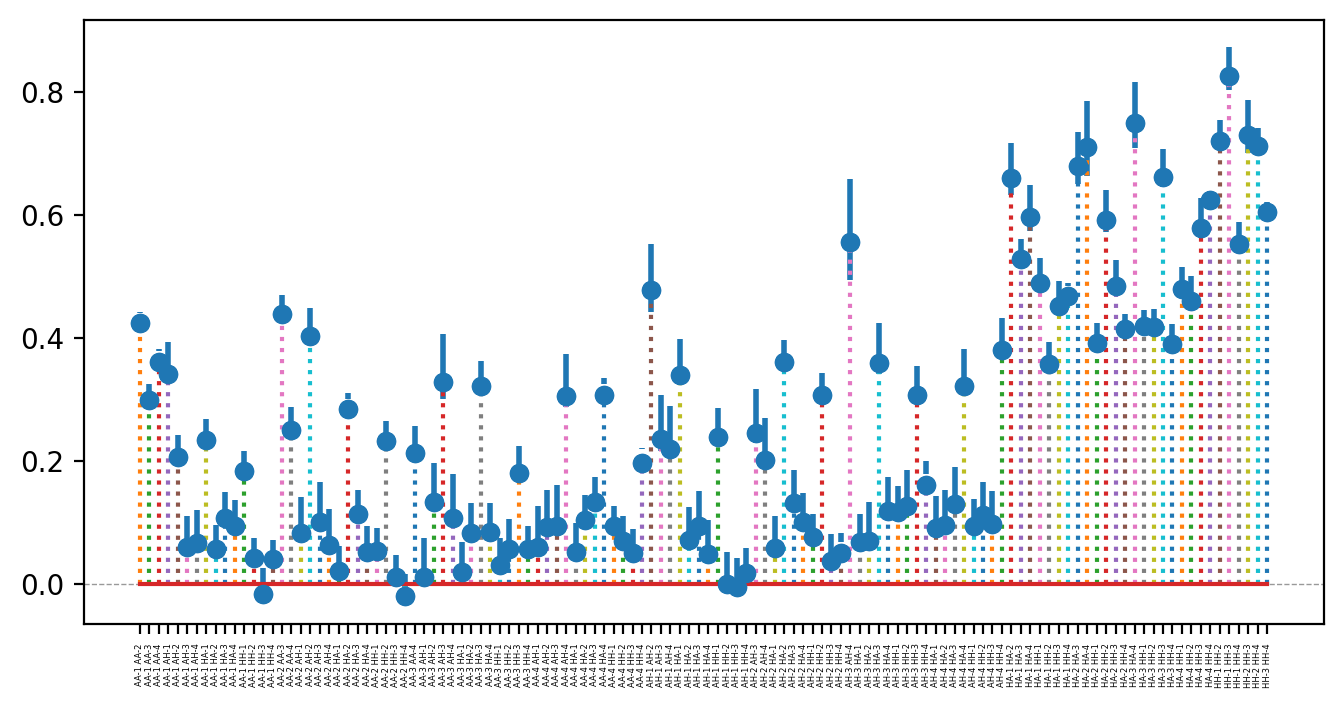

In [127]:
#plt.plot([1, 2, 3, 4])
#plt.ylabel('some numbers')
#plt.show()
    
mean = np.array([x[1] for x in combined_conv_corrs])
lower = np.array([x[0] for x in combined_conv_corrs])
upper = np.array([x[2] for x in combined_conv_corrs])

#print(lower)
#print(mean)
#print(upper)
#upper

all_labels = [sample_names[i[0]] + " " + sample_names[i[1]] for i in combs]

lower_bound, upper_bound = lower-mean, upper-mean

bounds = [lower_bound, upper_bound]
#print(bounds)
#fig = plt.figure()
plt.stem(all_labels, mean, linefmt = ':')

plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='o', linewidth=1, elinewidth=2)
plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
plt.xticks(rotation='vertical',fontsize=3)

#locs, labels = plt.xticks()
#print(labels)
#plt.axvline(x=locs, c='0.4', linewidth=0.5, linestyle="--")


#sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]

#rep_cov_plot(gw_covs_cis, sample_names)

### Genome-wide G

Averaging across replicates:

In [149]:
g_averep = d.calc_G(average_replicates=True)
with open('g_averep_AA.npy', 'wb') as f:
    np.save(f, g_averep)

Not averaging across replicates:

In [87]:
g = d.calc_G(average_replicates=False)
with open('g_AA.npy', 'wb') as f:
    np.save(f, g)

### Calculating Temporal-Replicate Covariances per Tile
Calculate the temporal-replicate covariances matrices for all tiles. Each covariance matrix has R x T = 8 rows and columns. 

In [88]:
tile_covs = d.calc_cov_by_tile(progress_bar=True)

/data/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/cvtk/cov.py:284: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/cvtk/cov.py:316: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(deltas, bias=True)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/data/users/r/b/rbr

We reshape these 8 x 8 matrices, extracting the temporal replicates. This gives the ntiles x T x T x R array of temporal covaraince matrices, for each of the R replicates. This numpy array is used to create figures. 

In [89]:
tile_temp_covs = stack_temporal_covs_by_group(tile_covs, d.R, d.T)

with open(f'tile_temporal_covs_AA_{tile_width_label}.npy', 'wb') as f:
    np.save(f, tile_temp_covs)